In [1]:
%matplotlib inline 
# 嵌入到notebook里面
from d2l import torch as d2l
import random
import torch

### 加载输入数据

根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数w=[2,−3.4]⊤
、b=4.2
和噪声项ϵ
生成数据集及其标签：

y=Xw+b+ϵ

In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # num_examples表示n个样本，len(w)表示样本的列数，此处应该是2
    y = torch.matmul(X, w) + b
    print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000])


In [3]:
print('features:', features[0], '\nlabel:',labels[0])

features: tensor([1.4685, 0.5341]) 
label: tensor([5.3197])


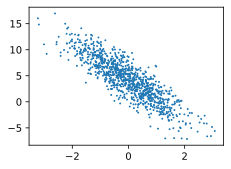

In [4]:
# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

### 读取数据集
回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)]) # 从i开始到 i+batch_size
        yield features[batch_indices], labels[batch_indices] # yield 表示 python的迭代器

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
    


tensor([[-1.0130,  0.6520],
        [-0.9528,  0.9048],
        [ 0.3310,  0.7453],
        [ 0.4244, -0.2986],
        [-0.1241,  1.1798],
        [ 1.0612,  0.6181],
        [-0.8474,  0.4700],
        [ 0.2451,  1.2255],
        [-1.4716,  0.1120],
        [ 0.7725, -1.2474]]) 
 tensor([[-0.0320],
        [-0.7580],
        [ 2.3179],
        [ 6.0649],
        [-0.0713],
        [ 4.2212],
        [ 0.9161],
        [ 0.5024],
        [ 0.8858],
        [ 9.9821]])


## 初始化模型参数
在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数。 在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0。

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [8]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数
因为需要计算损失函数的梯度，所以我们应该先定义损失函数。

在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [9]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化算法
在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。 

下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。每 一步更新的大小由学习速率lr决定。 

因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size） 来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [15]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 手动设置梯度=0

## 训练过程


In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.027168
epoch 2, loss 0.000102
epoch 3, loss 0.000050
